In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import skew
import feature_process_helper as fp
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline

## Lasso 1

### load data

In [91]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))
y = train.iloc[:, -1]
train = train.iloc[:, 1:-1]
test = test.iloc[:, 1:]
submission = test.iloc[:, 0]

### transform data

In [92]:
train, test = fp.mssubclass(train, test)
train, test = fp.lotfrontage(train, test)
train, test = fp.garageyrblt(train, test)
train, test = fp.impute(train, test)
train, test = fp.scale(train, test)
train, test = fp.dummies(train, test)

0.775806224312 seconds


### find optimal value of the Lasso alpha parameter

In [93]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import Lasso

alpha_ridge = [10, 20, 30, 40, 50]

coeffs = {}
z = 1.01
for alpha in alpha_ridge:
    r = Lasso(alpha=alpha, normalize=True, max_iter=1e5)
    r = r.fit(train, y)
    coeffs[str(z)+':'+str(alpha)] = np.append(r.score(train, y), np.append(r.intercept_, r.coef_))
    z += .01
    
grid_search = GridSearchCV(Lasso(alpha=alpha, normalize=True), param_grid={'alpha': alpha_ridge}, cv=10, n_jobs=-1)
grid_search.fit(train, y)

print grid_search.best_estimator_
print grid_search.score(train, y)

Lasso(alpha=40, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
0.884810357837


### inspect results

In [94]:
a = pd.DataFrame(coeffs).transpose()
columns = ['SCORE', 'INTERCEPT']+list(train.columns)
dict = {}
i = 0 
for c in columns:
    dict[i] = c
    i += 1
a.rename(columns = dict, inplace=True)
a

,SCORE,INTERCEPT,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLI,SaleType_CWD,SaleType_ConLw,SaleType_Con,SaleType_Oth,SaleCondition_Abnorml,SaleCondition_Partial,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family
1.01:10,0.906304,-359993.222673,-1122.756308,3654.279782,8470.834862,4629.287437,169.625163,53.201734,3273.654289,1926.747567,...,0.0,7957.921244,0.0,26102.174410,4985.049002,-6359.145133,0.0,0.0,7476.195193,-3038.878548
1.02:20,0.898402,-506952.906273,-0.000000,3000.613166,9254.420112,4285.713011,194.874230,70.794516,2615.415683,2296.354317,...,0.0,0.000000,0.0,20777.545869,0.000000,-5294.360250,0.0,-0.0,2153.758763,-1443.378045
1.03:30,0.891721,-521054.936396,-0.000000,2848.362989,10239.964851,3863.648048,197.905237,83.006815,2202.593985,2451.743806,...,0.0,0.000000,0.0,12578.858589,0.000000,-4493.565826,0.0,-0.0,0.000000,-0.000000
1.04:40,0.884810,-521680.564655,-0.000000,2744.919852,11119.319966,3363.147814,198.331603,99.756336,1902.662206,2645.859346,...,0.0,0.000000,0.0,3219.990762,0.000000,-3659.204473,0.0,-0.0,0.000000,-0.000000
1.05:50,0.878126,-524298.146483,0.000000,2678.808468,11885.404231,2917.920732,189.388979,109.267016,1723.804829,2788.017583,...,0.0,0.000000,-0.0,0.000000,0.000000,-2706.007992,0.0,-0.0,0.000000,-0.000000


### fit lasso model with optimal alpha

In [ ]:
lasso = Lasso(alpha=40, normalize=True, max_iter=1e5)
lasso = lasso.fit(train, y)

### last-second check that our test dataset doesn't contain empty columns

In [ ]:
for i in test.columns:
    if sum(pd.isnull(test[i])) > 0:
        print i, sum(pd.isnull(test[i]))

### predict test data and create submission file

In [ ]:
lasso.predict(test)

In [ ]:
predictions = lasso.predict(test)
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'lasso1.csv'), sep=",", index = False)

score: .013624

## Linear Regression 1

### load data

In [153]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))
y = train.iloc[:, -1]
train = train.iloc[:, 1:-1]
test = test.iloc[:, 1:]
submission = test.iloc[:, 0]

### transform data

In [154]:
train, test = fp.mssubclass(train, test)

In [155]:
def log(train, test, y):
    numeric_feats = train.dtypes[train.dtypes != "object"].index
    skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
    skewed_feats = skewed_feats[skewed_feats > 0.75]
    skewed_feats = skewed_feats.index
        
    for i in (train, test):
        #log transform skewed numeric features:
        i[skewed_feats] = np.log1p(i[skewed_feats])

    y = np.log1p(y)
    return train, test, y

In [156]:
train, test, y = log(train, test, y)

In [157]:
train, test = fp.lotfrontage(train, test)
train, test = fp.garageyrblt(train, test)
train, test = fp.impute(train, test)
train, test = fp.dummies(train, test)

0.87125754531 seconds


### use select K best to further narrow down number or columns

In [132]:
# Create SelectKBest() Object
kbest = SelectKBest()
lm = linear_model.LinearRegression()

# Create the Pipeline() obejct, and then fit it against the data set. 
pipeline = Pipeline([('kbest', kbest),
                     ('lm', lm)])

In [133]:
# Create a grid_search_dict. Using these with a pipeline can be a little tricky - note that
#    you have to specify which pipeline component you want to grid search by using the alias
#    you provided when you created the Pipeline object + '__' + [argument name]. 
grid_search_dict = {'kbest__k': range(1, len(train.columns)+1)}     

grid_search = GridSearchCV(pipeline, param_grid=grid_search_dict, cv=3, n_jobs=-1)
grid_search.fit(train, y)

# Let's see how our SelectKBest/GridSearch classifier performed
#print 'SelectKBest/GridSearch - Accuracy: ', grid_search.score(y, grid_search.predict(train))

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x000000000A085E48>)), ('lm', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'kbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, ...226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [134]:
print grid_search.best_params_
print grid_search.best_score_

{'kbest__k': 138}
0.882718827784


In [135]:
grid_search.best_estimator_

Pipeline(steps=[('kbest', SelectKBest(k=138, score_func=<function f_classif at 0x000000000A085E48>)), ('lm', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

### inspect results

In [136]:
grid_search = grid_search.best_estimator_
grid_search.fit(train, y)

# Let's see how our SelectKBest/GridSearch classifier performed
print 'SelectKBest/GridSearch - Accuracy: ', grid_search.score(train, y)

SelectKBest/GridSearch - Accuracy:  0.923857679057


### predict test data and create submission file

In [143]:
predictions = grid_search.predict(test)
predictions = np.expm1(predictions)
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'lm1.csv'), sep=",", index = False)

score: 0.13215

## Linear Regression 2

### load data

In [80]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))
y = train.iloc[:, -1]
train = train.iloc[:, 1:-1]
test = test.iloc[:, 1:]
submission = test.iloc[:, 0]

### transform data

In [81]:
train, test = fp.mssubclass(train, test)
train, test = fp.lotfrontage(train, test)
train, test = fp.garageyrblt(train, test)
train, test = fp.impute(train, test)
train, test = fp.dummies(train, test)

0.712638614368 seconds


### use select K best to further narrow down number or columns

In [82]:
# Create SelectKBest() Object
kbest = SelectKBest()
lm = linear_model.LinearRegression()

# Create the Pipeline() obejct, and then fit it against the data set. 
pipeline = Pipeline([('kbest', kbest),
                     ('lm', lm)])

In [83]:
# Create a grid_search_dict. Using these with a pipeline can be a little tricky - note that
#    you have to specify which pipeline component you want to grid search by using the alias
#    you provided when you created the Pipeline object + '__' + [argument name]. 
grid_search_dict = {'kbest__k': range(1, len(train.columns)+1)}     

grid_search = GridSearchCV(pipeline, param_grid=grid_search_dict, cv=3, n_jobs=-1)
grid_search.fit(train, y)

# Let's see how our SelectKBest/GridSearch classifier performed
#print 'SelectKBest/GridSearch - Accuracy: ', grid_search.score(y, grid_search.predict(train))

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x000000000AA61588>)), ('lm', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'kbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, ...226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [84]:
print grid_search.best_params_
print grid_search.best_score_

{'kbest__k': 198}
0.819652594611


In [85]:
grid_search.best_estimator_

Pipeline(steps=[('kbest', SelectKBest(k=198, score_func=<function f_classif at 0x000000000AA61588>)), ('lm', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

### inspect results

In [86]:
grid_search = grid_search.best_estimator_
grid_search.fit(train, y)

# Let's see how our SelectKBest/GridSearch classifier performed
print 'SelectKBest/GridSearch - Accuracy: ', grid_search.score(train, y)

SelectKBest/GridSearch - Accuracy:  0.909055724318


### predict test data and create submission file

In [87]:
predictions = grid_search.predict(test)
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'lm2.csv'), sep=",", index = False)

score: ERROR - one of the predictions was negative

## Lasso 2

Taking the log of the skewed numeric values

### load data

In [87]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))
y = train.iloc[:, -1]
train = train.iloc[:, 1:-1]
test = test.iloc[:, 1:]
submission = test.iloc[:, 0]

### transform data

In [88]:
train, test = fp.mssubclass(train, test)

In [89]:
def log(train, test, y):
    numeric_feats = train.dtypes[train.dtypes != "object"].index
    skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
    skewed_feats = skewed_feats[skewed_feats > 0.75]
    skewed_feats = skewed_feats.index
        
    for i in (train, test):
        #log transform skewed numeric features:
        i[skewed_feats] = np.log1p(i[skewed_feats])

    y = np.log1p(y)
    return train, test, y

In [90]:
train, test, y = log(train, test, y)

In [91]:
train, test = fp.lotfrontage(train, test)
train, test = fp.garageyrblt(train, test)
train, test = fp.impute(train, test)
train, test = fp.dummies(train, test)

0.749755348676 seconds


### find optimal value of the Lasso alpha parameter

In [69]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [71]:
alphas = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]
cv_lasso = [rmse_cv(Lasso(alpha = alpha)).mean() 
            for alpha in alphas]

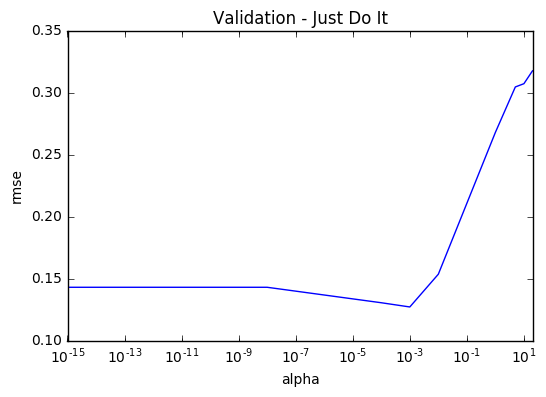

In [73]:
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Validation - Just Do It", logx=True)
plt.xlabel("alpha")
plt.ylabel("rmse")

In [102]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import Lasso

alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

coeffs = {}
for alpha in alpha_ridge:
    r = Lasso(alpha=alpha, normalize=True, max_iter=1000000)
    r = r.fit(train, y)
    
grid_search = GridSearchCV(Lasso(alpha=alpha, normalize=True), scoring='neg_mean_squared_error',
                           param_grid={'alpha': alpha_ridge}, cv=10, n_jobs=-1)
grid_search.fit(train, y)

print grid_search.best_estimator_
print grid_search.score(train, y)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
-0.0115547775381


### inspect results

#### how do different values of alpha compare to the rmse?

In [107]:
alpha = []
rmse = []
for i in range(0, len(grid_search.grid_scores_)):
    alpha.append(grid_search.grid_scores_[i][0]['alpha'])
    rmse.append(np.sqrt(-grid_search.grid_scores_[i][1]))

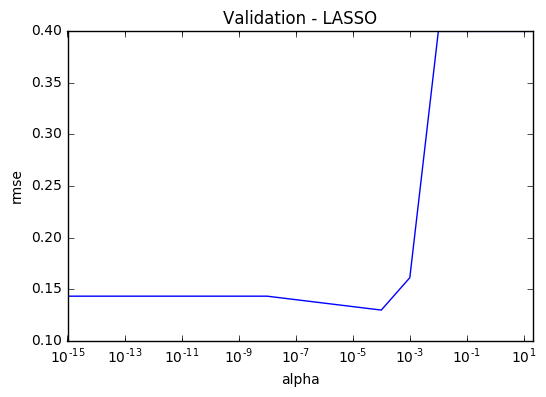

In [112]:
lasso_cv = pd.Series(rmse, index = alpha)
lasso_cv.plot(title = "Validation - LASSO", logx=True)
plt.xlabel("alpha")
plt.ylabel("rmse")

### fit lasso model with optimal alpha

In [57]:
lasso = Lasso(alpha=.0001, normalize=True, max_iter=1e6)
lasso = lasso.fit(train, y)

### inspect variable importance

In [58]:
coef = pd.Series(lasso.coef_, index = train.columns)

In [59]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 106 variables and eliminated the other 139 variables


In [60]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

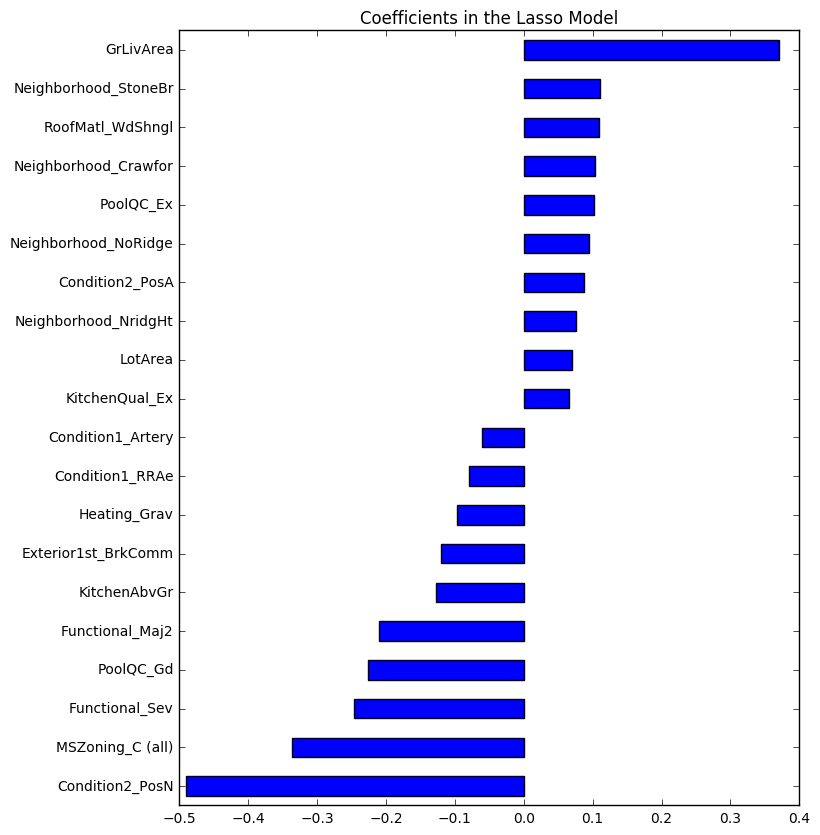

In [61]:
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

### predict test data and create submission file

In [62]:
lasso.predict(test)

array([ 11.70187494,  11.94682302,  12.10463334, ...,  12.0055574 ,
        11.70064338,  12.31396738])

In [63]:
predictions = lasso.predict(test)
predictions = np.expm1(predictions)
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'lasso2.csv'), sep=",", index = False)

score: .12328

## Lasso 3

Taking the log of ALL numeric values

### load data

In [118]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))
y = train.iloc[:, -1]
train = train.iloc[:, 1:-1]
test = test.iloc[:, 1:]
submission = test.iloc[:, 0]

### transform data

In [119]:
train, test = fp.mssubclass(train, test)

In [120]:
def log(train, test, y):
    numeric_feats = train.dtypes[train.dtypes != "object"].index
        
    for i in (train, test):
        #log transform skewed numeric features:
        i[numeric_feats] = np.log1p(i[numeric_feats])

    y = np.log1p(y)
    return train, test, y

In [121]:
train, test, y = log(train, test, y)

In [122]:
train, test = fp.lotfrontage(train, test)
train, test = fp.garageyrblt(train, test)
train, test = fp.impute(train, test)
#train, test = fp.scale(train, test)
train, test = fp.dummies(train, test)

0.8571121788 seconds


### find optimal value of the Lasso alpha parameter

In [123]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

coeffs = {}
for alpha in alpha_ridge:
    r = Lasso(alpha=alpha, normalize=True, max_iter=1000000)
    r = r.fit(train, y)
    
grid_search = GridSearchCV(Lasso(alpha=alpha, normalize=True), scoring='neg_mean_squared_error',
                           param_grid={'alpha': alpha_ridge}, cv=10, n_jobs=-1)
grid_search.fit(train, y)

print grid_search.best_estimator_
print grid_search.score(train, y)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
-0.0117627033334


### inspect results

#### how do different values of alpha compare to the rmse?

In [129]:
alpha = alpha_ridge
rmse = list(np.sqrt(-grid_search.cv_results_['mean_test_score']))

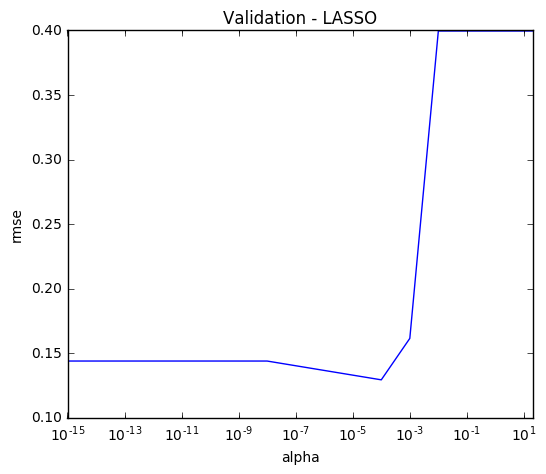

In [130]:
plt.figure(figsize=(6,5))
lasso_cv = pd.Series(rmse, index = alpha)
lasso_cv.plot(title = "Validation - LASSO", logx=True)
plt.xlabel("alpha")
plt.ylabel("rmse")

### fit lasso model with optimal alpha

In [131]:
lasso = Lasso(alpha=.0001, normalize=True, max_iter=1e6)
lasso = lasso.fit(train, y)

### inspect variable importance

In [132]:
coef = pd.Series(lasso.coef_, index = train.columns)

In [133]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 103 variables and eliminated the other 142 variables


In [134]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

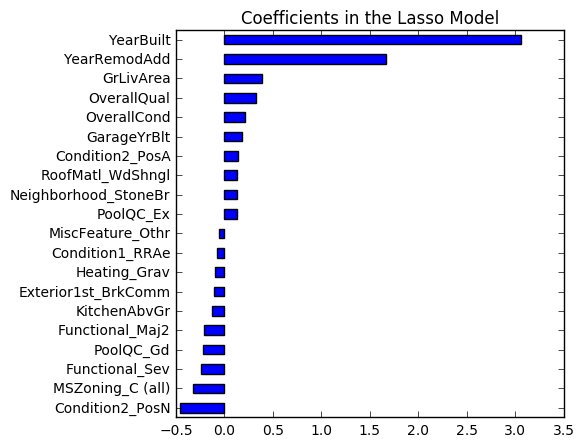

In [138]:
plt.rcParams['figure.figsize'] = (5.0, 5.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

### predict test data and create submission file

In [136]:
lasso.predict(test)

array([ 11.6892799 ,  11.95112217,  12.11326047, ...,  12.01074657,
        11.68627529,  12.29008701])

In [137]:
predictions = lasso.predict(test)
predictions = np.expm1(predictions)
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'lasso3.csv'), sep=",", index = False)

score: .12093

## Lasso 4

Taking the log of ALL numeric values and scaling the features (and turning Normalize=False)
...turns out this is not as good as doing Normalize=True

### load data

In [157]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))
y = train.iloc[:, -1]
train = train.iloc[:, 1:-1]
test = test.iloc[:, 1:]
submission = test.iloc[:, 0]

### transform data

In [158]:
train, test = fp.mssubclass(train, test)

In [159]:
def log(train, test, y):
    numeric_feats = train.dtypes[train.dtypes != "object"].index
        
    for i in (train, test):
        #log transform skewed numeric features:
        i[numeric_feats] = np.log1p(i[numeric_feats])

    y = np.log1p(y)
    return train, test, y

In [160]:
train, test, y = log(train, test, y)

In [161]:
train, test = fp.lotfrontage(train, test)
train, test = fp.garageyrblt(train, test)
train, test = fp.impute(train, test)
train, test = fp.scale(train, test, cols=train.dtypes[train.dtypes != "object"].index)
train, test = fp.dummies(train, test)

0.712770068811 seconds


### find optimal value of the Lasso alpha parameter

In [162]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

coeffs = {}
for alpha in alpha_ridge:
    r = Lasso(alpha=alpha, max_iter=1000000)
    r = r.fit(train, y)
    
grid_search = GridSearchCV(Lasso(alpha=alpha, normalize=True), scoring='neg_mean_squared_error',
                           param_grid={'alpha': alpha_ridge}, cv=10, n_jobs=-1)
grid_search.fit(train, y)

print grid_search.best_estimator_
print grid_search.score(train, y)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
-0.0117627033334


### inspect results

#### how do different values of alpha compare to the rmse?

In [163]:
alpha = alpha_ridge
rmse = list(np.sqrt(-grid_search.cv_results_['mean_test_score']))

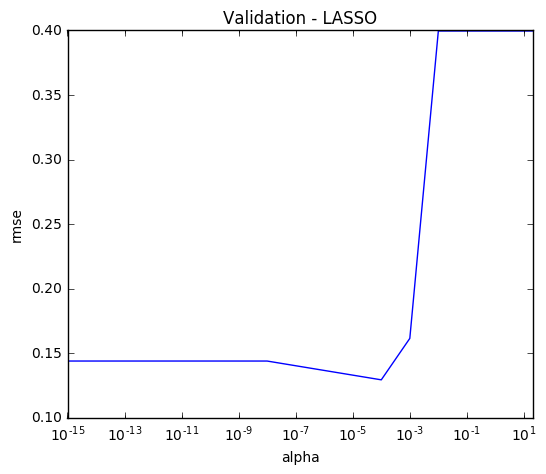

In [164]:
plt.figure(figsize=(6,5))
lasso_cv = pd.Series(rmse, index = alpha)
lasso_cv.plot(title = "Validation - LASSO", logx=True)
plt.xlabel("alpha")
plt.ylabel("rmse")

### fit lasso model with optimal alpha

In [165]:
lasso = Lasso(alpha=.0001, max_iter=1e6)
lasso = lasso.fit(train, y)

### inspect variable importance

In [166]:
coef = pd.Series(lasso.coef_, index = train.columns)

In [167]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 195 variables and eliminated the other 50 variables


In [168]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

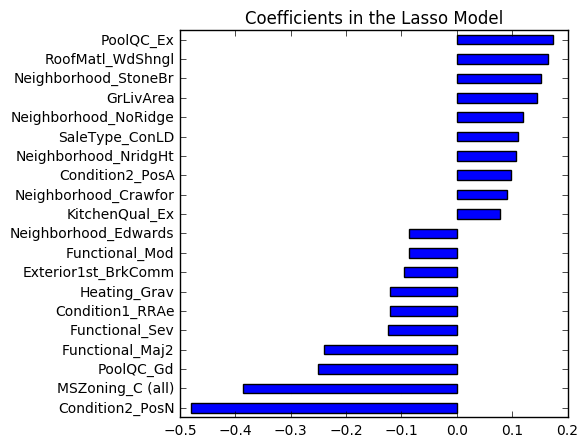

In [169]:
plt.rcParams['figure.figsize'] = (5.0, 5.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

### predict test data and create submission file

In [170]:
lasso.predict(test)

array([ 11.66292319,  11.9331901 ,  12.11437636, ...,  12.06081414,
        11.66438849,  12.27706938])

In [171]:
predictions = lasso.predict(test)
predictions = np.expm1(predictions)
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'lasso4.csv'), sep=",", index = False)

score: .12260

## Lasso 5

Taking the log of ALL numeric values and converting ordinal categorical vars to numeric

### load data

In [2]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))
y = train.iloc[:, -1]
train = train.iloc[:, 1:-1]
test = test.iloc[:, 1:]
submission = test.iloc[:, 0]

### transform data

In [3]:
train, test = fp.mssubclass(train, test)

In [4]:
train, test = fp.ordinal(train, test)

In [5]:
def log(train, test, y):
    numeric_feats = train.dtypes[train.dtypes != "object"].index
        
    for i in (train, test):
        #log transform skewed numeric features:
        i[numeric_feats] = np.log1p(i[numeric_feats])

    y = np.log1p(y)
    return train, test, y

In [6]:
train, test, y = log(train, test, y)

In [7]:
train, test = fp.lotfrontage(train, test)
train, test = fp.garageyrblt(train, test)
train, test = fp.impute(train, test)
train, test = fp.dummies(train, test)

0.468862863804 seconds


### find optimal value of the Lasso alpha parameter

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

coeffs = {}
for alpha in alpha_ridge:
    r = Lasso(alpha=alpha, normalize=True, max_iter=1000000)
    r = r.fit(train, y)
    
grid_search = GridSearchCV(Lasso(alpha=alpha, normalize=True), scoring='neg_mean_squared_error',
                           param_grid={'alpha': alpha_ridge}, cv=10, n_jobs=-1)
grid_search.fit(train, y)

print grid_search.best_estimator_
print grid_search.score(train, y)

C:\Users\User\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
-0.0124766457865


### inspect results

#### how do different values of alpha compare to the rmse?

In [10]:
alpha = alpha_ridge
rmse = list(np.sqrt(-grid_search.cv_results_['mean_test_score']))

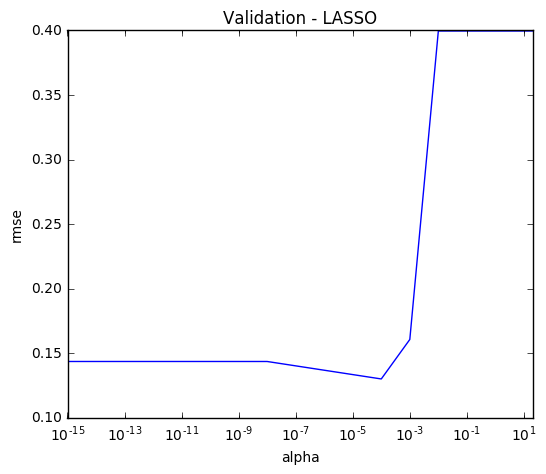

In [11]:
plt.figure(figsize=(6,5))
lasso_cv = pd.Series(rmse, index = alpha)
lasso_cv.plot(title = "Validation - LASSO", logx=True)
plt.xlabel("alpha")
plt.ylabel("rmse")

### fit lasso model with optimal alpha

In [12]:
lasso = Lasso(alpha=.0001, normalize=True, max_iter=1e6)
lasso = lasso.fit(train, y)

### inspect variable importance

In [13]:
coef = pd.Series(lasso.coef_, index = train.columns)

In [14]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 87 variables and eliminated the other 125 variables


In [15]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

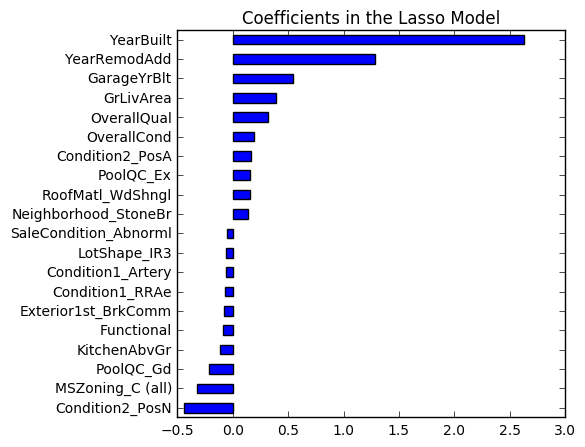

In [16]:
plt.rcParams['figure.figsize'] = (5.0, 5.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

### predict test data and create submission file

In [18]:
def impute(train, test):
    for i in (train, test):
        for s in [k for k in i.dtypes[i.dtypes != "object"].index if sum(pd.isnull(i[k])>0)]:
            i[s] = i[s].fillna(0)
    return train, test

In [19]:
train, test = impute(train, test)

In [20]:
lasso.predict(test)

array([ 11.67345253,  11.97199209,  12.10655513, ...,  12.00143713,
        11.69654833,  12.3242625 ])

In [21]:
predictions = lasso.predict(test)
predictions = np.expm1(predictions)
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'lasso5.csv'), sep=",", index = False)

score: .12532

## Lasso 6

Taking the log of ALL numeric values impute w/ mean

### load data

In [164]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))
y = train.iloc[:, -1]
train = train.iloc[:, 1:-1]
test = test.iloc[:, 1:]
submission = test.iloc[:, 0]

### transform data

In [165]:
train, test = fp.mssubclass(train, test)

In [166]:
def log(train, test, y):
    numeric_feats = train.dtypes[train.dtypes != "object"].index
        
    for i in (train, test):
        #log transform skewed numeric features:
        i[numeric_feats] = np.log1p(i[numeric_feats])

    y = np.log1p(y)
    return train, test, y

In [167]:
train, test, y = log(train, test, y)

In [168]:
train, test = fp.lotfrontage(train, test)
train, test = fp.garageyrblt(train, test)
train, test = fp.impute_mean(train, test)
train, test = fp.dummies(train, test)

0.789759343621 seconds


### find optimal value of the Lasso alpha parameter

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

coeffs = {}
for alpha in alpha_ridge:
    r = Lasso(alpha=alpha, normalize=True, max_iter=1000000)
    r = r.fit(train, y)
    
grid_search = GridSearchCV(Lasso(alpha=alpha, normalize=True), scoring='neg_mean_squared_error',
                           param_grid={'alpha': alpha_ridge}, cv=10, n_jobs=-1)
grid_search.fit(train, y)

print grid_search.best_estimator_
print grid_search.score(train, y)

C:\Users\User\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
-0.01176265768


### inspect results

#### how do different values of alpha compare to the rmse?

In [8]:
alpha = alpha_ridge
rmse = list(np.sqrt(-grid_search.cv_results_['mean_test_score']))

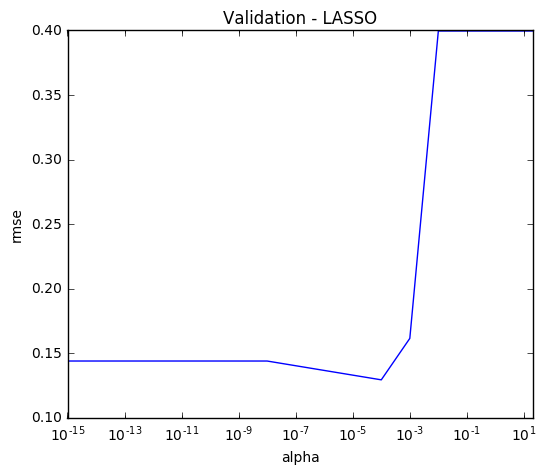

In [9]:
plt.figure(figsize=(6,5))
lasso_cv = pd.Series(rmse, index = alpha)
lasso_cv.plot(title = "Validation - LASSO", logx=True)
plt.xlabel("alpha")
plt.ylabel("rmse")

### fit lasso model with optimal alpha

In [169]:
lasso = Lasso(alpha=.0001, normalize=True, max_iter=1e6)
lasso = lasso.fit(train, y)

### inspect variable importance

In [170]:
coef = pd.Series(lasso.coef_, index = train.columns)

In [67]:
coef[coef != 0].index

Index([u'LotArea', u'OverallQual', u'OverallCond', u'YearBuilt',
       u'YearRemodAdd', u'BsmtFinSF1', u'TotalBsmtSF', u'1stFlrSF',
       u'GrLivArea', u'BsmtFullBath',
       ...
       u'GarageCond_Fa', u'PoolQC_Ex', u'PoolQC_Gd', u'Fence_GdWo',
       u'MiscFeature_Othr', u'SaleType_New', u'SaleType_ConLD',
       u'SaleType_Con', u'SaleCondition_Abnorml', u'SaleCondition_Family'],
      dtype='object', length=103)

In [68]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 103 variables and eliminated the other 142 variables


In [69]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

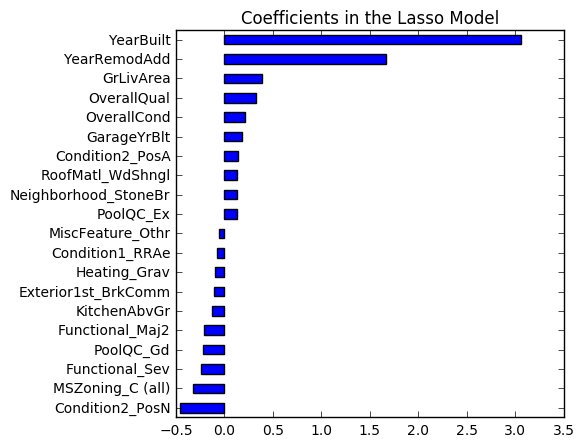

In [14]:
plt.rcParams['figure.figsize'] = (5.0, 5.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

### predict test data and create submission file

In [70]:
lasso.predict(test)

array([ 11.68927581,  11.95111481,  12.11327219, ...,  12.01075463,
        11.68626894,  12.29008417])

In [17]:
predictions = lasso.predict(test)
predictions = np.expm1(predictions)
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'lasso6.csv'), sep=",", index = False)

score: .12090

## Lasso 7

Taking the log of ALL numeric values impute w/ mean

### load data

In [120]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))
y = train.iloc[:, -1]
train = train.iloc[:, 1:-1]
test = test.iloc[:, 1:]
submission = test.iloc[:, 0]

### transform data

In [121]:
train, test = fp.mssubclass(train, test, cols=['MSSubClass', 'MoSold', 'YrSold'])

In [122]:
def log(train, test, y):
    numeric_feats = train.dtypes[train.dtypes != "object"].index
        
    for i in (train, test):
        #log transform skewed numeric features:
        i[numeric_feats] = np.log1p(i[numeric_feats])

    y = np.log1p(y)
    return train, test, y

In [123]:
train, test, y = log(train, test, y)

In [124]:
train, test = fp.lotfrontage(train, test)
train, test = fp.garageyrblt(train, test)
train, test = fp.impute_mean(train, test)
train, test = fp.dummies(train, test)

0.779527214036 seconds


### find optimal value of the Lasso alpha parameter

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_ridge = [1e-8, 1e-5, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]

coeffs = {}
for alpha in alpha_ridge:
    r = Lasso(alpha=alpha, normalize=True, max_iter=1000000)
    r = r.fit(train, y)
    
grid_search = GridSearchCV(Lasso(alpha=alpha, normalize=True), scoring='neg_mean_squared_error',
                           param_grid={'alpha': alpha_ridge}, cv=10, n_jobs=-1)
grid_search.fit(train, y)

print grid_search.best_estimator_
print grid_search.score(train, y)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
-0.0117281074993


### inspect results

#### how do different values of alpha compare to the rmse?

In [13]:
alpha = alpha_ridge
rmse = list(np.sqrt(-grid_search.cv_results_['mean_test_score']))

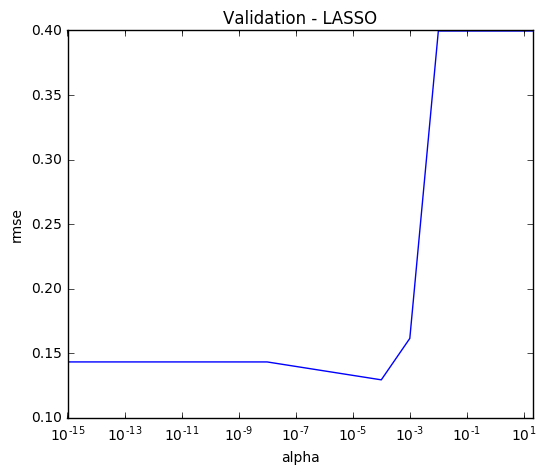

In [14]:
plt.figure(figsize=(6,5))
lasso_cv = pd.Series(rmse, index = alpha)
lasso_cv.plot(title = "Validation - LASSO", logx=True)
plt.xlabel("alpha")
plt.ylabel("rmse")

### fit lasso model with optimal alpha

In [125]:
lasso = Lasso(alpha=.0001, normalize=True, max_iter=1e6)
lasso = lasso.fit(train, y)

### inspect variable importance

In [9]:
coef = pd.Series(lasso.coef_, index = train.columns)

In [10]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 108 variables and eliminated the other 150 variables


In [11]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

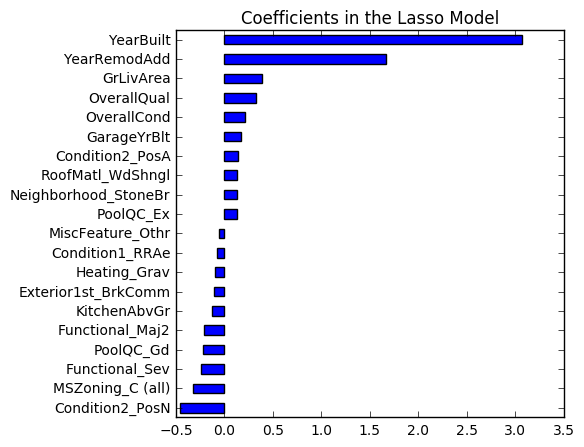

In [12]:
plt.rcParams['figure.figsize'] = (5.0, 5.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

### predict test data and create submission file

In [13]:
lasso.predict(test)

array([ 11.68968517,  11.95174103,  12.11310008, ...,  12.01131245,
        11.68757895,  12.29017436])

In [14]:
predictions = lasso.predict(test)
predictions = np.expm1(predictions)
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'lasso7.csv'), sep=",", index = False)

score: .12087

## Lasso 8

Taking the log of ALL numeric values impute w/ mean

### load data

In [35]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))
y = train.iloc[:, -1]
train = train.iloc[:, 1:-1]
test = test.iloc[:, 1:]
submission = test.iloc[:, 0]

### transform data

In [36]:
train, test = fp.mssubclass(train, test, cols=['MSSubClass', 'MoSold', 'YrSold'])

In [37]:
for i in [train, test]:
    for z in ['YearBuilt', 'YearRemodAdd']:
        i[z] = i[z] + np.square(i[z]) + (i[z])**3

In [38]:
for i in [test, train]:
    i['Age'] = i[['YearBuilt', 'YearRemodAdd']].max(axis=1) - train['YearBuilt'].min()
    del i['YearBuilt']
    del i['YearRemodAdd']

In [39]:
def log(train, test, y):
    numeric_feats = train.dtypes[train.dtypes != "object"].index
        
    for i in (train, test):
        #log transform skewed numeric features:
        i[numeric_feats] = np.log1p(i[numeric_feats])

    y = np.log1p(y)
    return train, test, y

In [40]:
train, test, y = log(train, test, y)

In [41]:
train, test = fp.lotfrontage(train, test)
train, test = fp.garageyrblt(train, test)
train, test = fp.impute_mean(train, test)
train, test = fp.dummies(train, test)

0.913091243989 seconds


### find optimal value of the Lasso alpha parameter

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_ridge = [1e-8, 1e-5, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]

coeffs = {}
for alpha in alpha_ridge:
    r = Lasso(alpha=alpha, normalize=True, max_iter=1000000)
    r = r.fit(train, y)
    
grid_search = GridSearchCV(Lasso(alpha=alpha, normalize=True), scoring='neg_mean_squared_error',
                           param_grid={'alpha': alpha_ridge}, cv=10, n_jobs=-1)
grid_search.fit(train, y)

print grid_search.best_estimator_
print grid_search.score(train, y)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
-0.0118186669933


### inspect results

#### how do different values of alpha compare to the rmse?

In [44]:
alpha = alpha_ridge
rmse = list(np.sqrt(-grid_search.cv_results_['mean_test_score']))

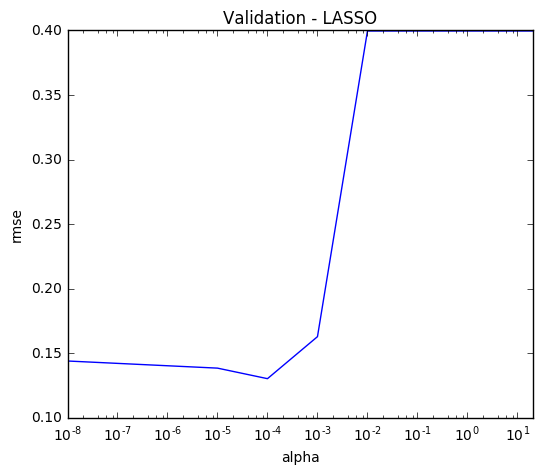

In [45]:
plt.figure(figsize=(6,5))
lasso_cv = pd.Series(rmse, index = alpha)
lasso_cv.plot(title = "Validation - LASSO", logx=True)
plt.xlabel("alpha")
plt.ylabel("rmse")

### fit lasso model with optimal alpha

In [46]:
lasso = Lasso(alpha=.0001, normalize=True, max_iter=1e6)
lasso = lasso.fit(train, y)

### inspect variable importance

In [47]:
coef = pd.Series(lasso.coef_, index = train.columns)

In [48]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 120 variables and eliminated the other 137 variables


In [49]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

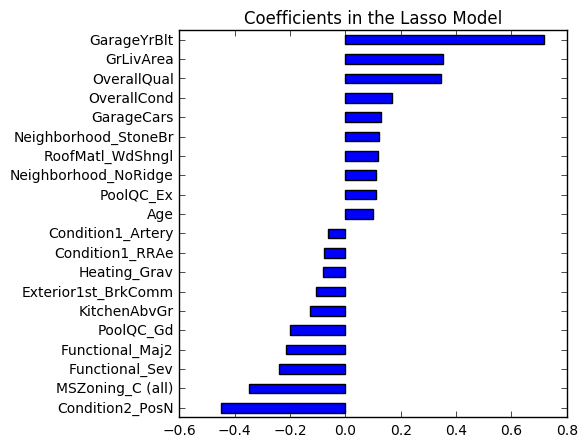

In [50]:
plt.rcParams['figure.figsize'] = (5.0, 5.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

### predict test data and create submission file

In [51]:
lasso.predict(test)

array([ 11.68068019,  11.9494957 ,  12.09992908, ...,  12.01647258,
        11.66691825,  12.29404611])

In [52]:
predictions = lasso.predict(test)
predictions = np.expm1(predictions)
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'lasso8.csv'), sep=",", index = False)

score: 0.12272

## XGBoost 1

In [33]:
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error

### load data

In [105]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))
y = train.iloc[:, -1]
train = train.iloc[:, 1:-1]
test = test.iloc[:, 1:]
submission = test.iloc[:, 0]

### transform data

In [106]:
train, test = fp.mssubclass(train, test)

In [107]:
def log(train, test, y):
    numeric_feats = train.dtypes[train.dtypes != "object"].index
        
    for i in (train, test):
        #log transform skewed numeric features:
        i[numeric_feats] = np.log1p(i[numeric_feats])

    y = np.log1p(y)
    return train, test, y

In [108]:
train, test, y = log(train, test, y)

In [109]:
train, test = fp.lotfrontage(train, test)
train, test = fp.garageyrblt(train, test)
train, test = fp.impute_mean(train, test)
train, test = fp.dummies(train, test)

0.720260998249 seconds


In [110]:
regr = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)

regr.fit(train, y)

# Run prediction on training set to get a rough idea of how well it does.
y_pred = regr.predict(train)
y_test = y
print("XGBoost score on training set: ", mean_squared_error(y_test, y_pred))

# Run prediction on the Kaggle test set.
y_pred_xgb = regr.predict(test)

('XGBoost score on training set: ', 0.0058807337725166504)


### predict test data and create submission file

In [84]:
y_pred_xgb

array([ 11.75356579,  11.97429276,  12.10027695, ...,  12.04427624,
        11.69212246,  12.2768383 ], dtype=float32)

In [85]:
predictions = np.expm1(y_pred_xgb)
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'xgb1.csv'), sep=",", index = False)

score 0.12278

## XGBoost 2

In [77]:
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error

### load data

In [91]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))
y = train.iloc[:, -1]
train = train.iloc[:, 1:-1]
test = test.iloc[:, 1:]
submission = test.iloc[:, 0]

### transform data

In [92]:
train, test = fp.mssubclass(train, test)

In [93]:
def log(train, test, y):
    numeric_feats = train.dtypes[train.dtypes != "object"].index
        
    for i in (train, test):
        #log transform skewed numeric features:
        i[numeric_feats] = np.log1p(i[numeric_feats])

    y = np.log1p(y)
    return train, test, y

In [94]:
train, test, y = log(train, test, y)

In [95]:
train, test = fp.lotfrontage(train, test)
train, test = fp.garageyrblt(train, test)
train, test = fp.impute_mean(train, test)
train, test = fp.dummies(train, test)

0.691060347853 seconds


In [28]:
regr = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)

regr.fit(train, y)

# Run prediction on training set to get a rough idea of how well it does.
y_pred = regr.predict(train)
y_test = y
print("XGBoost score on training set: ", mean_squared_error(y_test, y_pred))

# Run prediction on the Kaggle test set.
y_pred_xgb = regr.predict(test)

('XGBoost score on training set: ', 0.0058807337725166504)


In [83]:
xgdmat = xgb.DMatrix(train.values, y)

#modelfit(regr, train,y.values.ravel())

our_params = {'eta': 0.01, 'seed':0, 'subsample': 0.2, 'colsample_bytree': 0.2, 'min_child_weight':1.5, 'max_depth':4
             } 

cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 8000, nfold = 3,
                early_stopping_rounds = 50) # Look for early stopping that minimizes error

cv_xgb

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
0,11.415955,0.007503,11.415957,0.003646
1,11.302685,0.007582,11.302688,0.003573
2,11.190407,0.007671,11.190409,0.003495
3,11.079280,0.007816,11.079282,0.003360
4,10.969424,0.007829,10.969426,0.003357
5,10.860324,0.008057,10.860326,0.003140
6,10.752078,0.008051,10.752079,0.003157
7,10.645191,0.008100,10.645192,0.003131
8,10.539581,0.007943,10.539584,0.003326
9,10.435270,0.007587,10.435272,0.003670


In [89]:
# STEP 2: Tune max_depth and min_child_weight

param_test1 = cv_params = {'max_depth': [3, 4, 5, 6], 'min_child_weight': np.arange(1, 4, .5)}

gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.01, n_estimators=1945,
                                                  gamma=0, subsample=0.2, colsample_bytree=0.2,
                                                  nthread=4, scale_pos_weight=1, seed=27),
                                                  param_grid = param_test1, scoring='neg_mean_squared_error', iid=False, cv=3)

gsearch1.fit(train,y.values.ravel())

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_


C:\Users\User\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.01512, std: 0.00259, params: {'max_depth': 3, 'min_child_weight': 1.0},
  mean: -0.01534, std: 0.00255, params: {'max_depth': 3, 'min_child_weight': 1.5},
  mean: -0.01534, std: 0.00255, params: {'max_depth': 3, 'min_child_weight': 2.0},
  mean: -0.01564, std: 0.00273, params: {'max_depth': 3, 'min_child_weight': 2.5},
  mean: -0.01564, std: 0.00273, params: {'max_depth': 3, 'min_child_weight': 3.0},
  mean: -0.01580, std: 0.00259, params: {'max_depth': 3, 'min_child_weight': 3.5},
  mean: -0.01483, std: 0.00259, params: {'max_depth': 4, 'min_child_weight': 1.0},
  mean: -0.01525, std: 0.00249, params: {'max_depth': 4, 'min_child_weight': 1.5},
  mean: -0.01525, std: 0.00249, params: {'max_depth': 4, 'min_child_weight': 2.0},
  mean: -0.01550, std: 0.00267, params: {'max_depth': 4, 'min_child_weight': 2.5},
  mean: -0.01550, std: 0.00267, params: {'max_depth': 4, 'min_child_weight': 3.0},
  mean: -0.01582, std: 0.00262, params: {'max_depth': 4, 'min_child_weight': 3.5},
  me

In [91]:
# STEP 3: Tune gamma

## apparently, we want to tune the n_estimators after each hyperparameter tuning round...

param_test2 = {'gamma':[i/10.0 for i in range(0,5)]}

gsearch2 = GridSearchCV(estimator = xgb.XGBRegressor( learning_rate =0.01, n_estimators=1945, max_depth=4, min_child_weight=1,
                                                  gamma=0, subsample=0.2, colsample_bytree=0.2,
                                                  nthread=4, scale_pos_weight=1, seed=27),
                                                  param_grid = param_test2, scoring='neg_mean_squared_error', iid=False, cv=3)

gsearch2.fit(train,y.values.ravel())

gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

C:\Users\User\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.01483, std: 0.00259, params: {'gamma': 0.0},
  mean: -0.01615, std: 0.00284, params: {'gamma': 0.1},
  mean: -0.01786, std: 0.00298, params: {'gamma': 0.2},
  mean: -0.01952, std: 0.00313, params: {'gamma': 0.3},
  mean: -0.02117, std: 0.00321, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 -0.014833541063736707)

In [92]:
[i/10.0 for i in range(6,10)]

[0.6, 0.7, 0.8, 0.9]

In [93]:
# STEP 4: Tune subsample and colsample_bytree

param_test3 = cv_params = {'subsample':[i/10.0 for i in range(1,10)],
                                        'colsample_bytree':[i/10.0 for i in range(1,10)]}

gsearch3 = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate =0.01, n_estimators=1945, max_depth=4, min_child_weight=1,
                                                  gamma=0,
                                                  nthread=4, scale_pos_weight=1, seed=27),
                                                  param_grid = param_test3, scoring='neg_mean_squared_error', iid=False, cv=3)

gsearch3.fit(train,y.values.ravel())

gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

C:\Users\User\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.01626, std: 0.00284, params: {'subsample': 0.1, 'colsample_bytree': 0.1},
  mean: -0.01565, std: 0.00291, params: {'subsample': 0.2, 'colsample_bytree': 0.1},
  mean: -0.01505, std: 0.00307, params: {'subsample': 0.3, 'colsample_bytree': 0.1},
  mean: -0.01498, std: 0.00298, params: {'subsample': 0.4, 'colsample_bytree': 0.1},
  mean: -0.01490, std: 0.00287, params: {'subsample': 0.5, 'colsample_bytree': 0.1},
  mean: -0.01477, std: 0.00304, params: {'subsample': 0.6, 'colsample_bytree': 0.1},
  mean: -0.01466, std: 0.00296, params: {'subsample': 0.7, 'colsample_bytree': 0.1},
  mean: -0.01477, std: 0.00294, params: {'subsample': 0.8, 'colsample_bytree': 0.1},
  mean: -0.01495, std: 0.00302, params: {'subsample': 0.9, 'colsample_bytree': 0.1},
  mean: -0.01563, std: 0.00243, params: {'subsample': 0.1, 'colsample_bytree': 0.2},
  mean: -0.01483, std: 0.00259, params: {'subsample': 0.2, 'colsample_bytree': 0.2},
  mean: -0.01471, std: 0.00290, params: {'subsample': 0.3, 'colsa

In [94]:
# STEP 5: Tuning Regularization Parameters

param_test4 = cv_params = {'reg_alpha':[1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1]}

gsearch4 = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate =0.01, n_estimators=1945, max_depth=4, min_child_weight=1,
                                                  gamma=0, subsample=0.4, colsample_bytree=0.3,
                                                  nthread=4, scale_pos_weight=1, seed=27),
                                                  param_grid = param_test4, scoring='neg_mean_squared_error', iid=False, cv=3)

gsearch4.fit(train,y.values.ravel())

gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_


C:\Users\User\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.01463, std: 0.00300, params: {'reg_alpha': 1e-05},
  mean: -0.01466, std: 0.00299, params: {'reg_alpha': 0.0001},
  mean: -0.01466, std: 0.00298, params: {'reg_alpha': 0.001},
  mean: -0.01463, std: 0.00291, params: {'reg_alpha': 0.01},
  mean: -0.01477, std: 0.00266, params: {'reg_alpha': 0.1},
  mean: -0.01572, std: 0.00235, params: {'reg_alpha': 1}],
 {'reg_alpha': 1e-05},
 -0.014628132787006941)

In [94]:
# STEP 5: Tuning Regularization Parameters

param_test4 = cv_params = {'reg_alpha':[1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1]}

gsearch4 = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate =0.01, n_estimators=1945, max_depth=4, min_child_weight=1,
                                                  gamma=0, subsample=0.4, colsample_bytree=0.3, reg_alpha=1e-5, 
                                                  nthread=4, scale_pos_weight=1, seed=27),
                                                  param_grid = param_test4, scoring='neg_mean_squared_error', iid=False, cv=3)

gsearch4.fit(train,y.values.ravel())

gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_


C:\Users\User\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.01463, std: 0.00300, params: {'reg_alpha': 1e-05},
  mean: -0.01466, std: 0.00299, params: {'reg_alpha': 0.0001},
  mean: -0.01466, std: 0.00298, params: {'reg_alpha': 0.001},
  mean: -0.01463, std: 0.00291, params: {'reg_alpha': 0.01},
  mean: -0.01477, std: 0.00266, params: {'reg_alpha': 0.1},
  mean: -0.01572, std: 0.00235, params: {'reg_alpha': 1}],
 {'reg_alpha': 1e-05},
 -0.014628132787006941)

In [95]:
# find final # of rounds

xgdmat = xgb.DMatrix(train.values, y)

#modelfit(regr, train,y.values.ravel())

our_params = {'eta': 0.01, 'seed':0, 'subsample': 0.4, 'colsample_bytree': 0.3, 'gamma': 0,
              'reg_alpha': 1e-5, 'max_depth': 4, 'min_child_weight': 1
             } 

cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 8000, nfold = 3,
                early_stopping_rounds = 50) # Look for early stopping that minimizes error

cv_xgb

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
0,11.415664,0.007413,11.415666,0.003735
1,11.301905,0.007558,11.301907,0.003611
2,11.189232,0.007615,11.189234,0.003558
3,11.077864,0.007741,11.077865,0.003444
4,10.967658,0.007892,10.967660,0.003302
5,10.858365,0.007964,10.858367,0.003245
6,10.750138,0.008100,10.750140,0.003125
7,10.643031,0.008216,10.643033,0.003021
8,10.537177,0.008037,10.537180,0.003215
9,10.432454,0.007894,10.432455,0.003374


In [96]:
# final model

xgdmat = xgb.DMatrix(train.values, y)

regr = xgb.XGBRegressor(
                 colsample_bytree=0.3,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1,
                 n_estimators=1668,                                                                  
                 reg_alpha=1e-5,
                 subsample=0.4,
                 seed=42,
                 silent=1)

regr.fit(train, y)

# Run prediction on training set to get a rough idea of how well it does.
y_pred = regr.predict(train)
y_test = y
print("XGBoost score on training set: ", mean_squared_error(y_test, y_pred))

# Run prediction on the Kaggle test set.
y_pred_xgb = regr.predict(test)

('XGBoost score on training set: ', 0.0045278368745048812)


### predict test data and create submission file

In [97]:
y_pred_xgb

array([ 11.76618958,  11.97465134,  12.12652588, ...,  12.03920841,
        11.6956768 ,  12.32116222], dtype=float32)

In [98]:
predictions = np.expm1(y_pred_xgb)
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'xgb2.csv'), sep=",", index = False)

score: 0.12558

## Blended 1

lasso6 and xgb1

In [86]:
y_pred_xgb

array([ 11.75356579,  11.97429276,  12.10027695, ...,  12.04427624,
        11.69212246,  12.2768383 ], dtype=float32)

In [104]:
predictions = np.expm1((lasso.predict(test) + y_pred_xgb)/2)

In [95]:
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'blended2.csv'), sep=",", index = False)

score: .11768

## Blended 2

lasso6 and xgb2

In [86]:
y_pred_xgb

array([ 11.75356579,  11.97429276,  12.10027695, ...,  12.04427624,
        11.69212246,  12.2768383 ], dtype=float32)

In [105]:
predictions = np.expm1((lasso.predict(test) + y_pred_xgb)/2)

In [106]:
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'blended2.csv'), sep=",", index = False)

## Blended 3

70% lasso6 and 30% xgb1

In [116]:
y_pred_xgb

array([ 11.75356579,  11.97429276,  12.10027695, ...,  12.04427624,
        11.69212246,  12.2768383 ], dtype=float32)

In [123]:
lasso.predict(test)

array([ 11.68927581,  11.95111481,  12.11327219, ...,  12.01075463,
        11.68626894,  12.29008417])

In [126]:
predictions = np.expm1((.7*lasso.predict(test) + .3*y_pred_xgb))

In [127]:
predictions

array([ 121607.5970132 ,  156070.3239044 ,  181564.88273759, ...,
        166176.39858767,  119135.48487473,  216664.61664824])

In [128]:
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'blended3.csv'), sep=",", index = False)

score: .11796

## Blended 5

60% lasso6 and 40% xgb1

### load data

In [137]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))
y = train.iloc[:, -1]
train = train.iloc[:, 1:-1]
test = test.iloc[:, 1:]
submission = test.iloc[:, 0]

### transform data

In [139]:
train, test = fp.mssubclass(train, test)

In [140]:
def log(train, test, y):
    numeric_feats = train.dtypes[train.dtypes != "object"].index
        
    for i in (train, test):
        #log transform skewed numeric features:
        i[numeric_feats] = np.log1p(i[numeric_feats])

    y = np.log1p(y)
    return train, test, y

In [141]:
train, test, y = log(train, test, y)

In [142]:
train, test = fp.lotfrontage(train, test)
train, test = fp.garageyrblt(train, test)
train, test = fp.impute_mean(train, test)
train, test = fp.dummies(train, test)

0.688420205772 seconds


In [116]:
y_pred_xgb

array([ 11.75356579,  11.97429276,  12.10027695, ...,  12.04427624,
        11.69212246,  12.2768383 ], dtype=float32)

In [123]:
lasso.predict(test)

array([ 11.68927581,  11.95111481,  12.11327219, ...,  12.01075463,
        11.68626894,  12.29008417])

In [143]:
predictions = np.expm1((.6*lasso.predict(test) + .4*y_pred_xgb))

In [144]:
predictions

array([ 122391.94283811,  156432.46974447,  181329.04343227, ...,
        166734.36272817,  119205.22495658,  216377.85545024])

In [145]:
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'blended5.csv'), sep=",", index = False)

score: 0.11765

## Random Forest Regression 1

### load data

In [25]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))
y = train.iloc[:, -1]
train = train.iloc[:, 1:-1]
test = test.iloc[:, 1:]
submission = test.iloc[:, 0]

### transform data

In [27]:
train, test = fp.mssubclass(train, test)

In [28]:
def log(train, test, y):
    numeric_feats = train.dtypes[train.dtypes != "object"].index
        
    for i in (train, test):
        #log transform skewed numeric features:
        i[numeric_feats] = np.log1p(i[numeric_feats])

    y = np.log1p(y)
    return train, test, y

In [29]:
train, test, y = log(train, test, y)

In [30]:
train, test = fp.lotfrontage(train, test)
train, test = fp.garageyrblt(train, test)
train, test = fp.impute_mean(train, test)
train, test = fp.dummies(train, test)

0.749942464009 seconds


In [31]:
forest = RandomForestRegressor(n_estimators=1000, 
                               criterion='mse', 
                               random_state=1, 
                               oob_score=True, 
                               n_jobs=-1)

forest.fit(train, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=True, random_state=1,
           verbose=0, warm_start=False)

Looking at the root mean squared error of our training set, we can see that there overfitting is likely happening. 

In [15]:
y_train_pred = forest.predict(train)
np.sqrt(mean_squared_error(y, y_train_pred))

0.051996390866758724

In [25]:
predictions = forest.predict(test)
predictions = np.expm1(predictions)

In [26]:
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'RFR1.csv'), sep=",", index = False)

score: 0.14585

## Random Forest Regression 2

### load data

In [2]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))
y = train.iloc[:, -1]
train = train.iloc[:, 1:-1]
test = test.iloc[:, 1:]
submission = test.iloc[:, 0]

### transform data

In [3]:
train, test = fp.mssubclass(train, test)

In [4]:
def log(train, test, y):
    numeric_feats = train.dtypes[train.dtypes != "object"].index
        
    for i in (train, test):
        #log transform skewed numeric features:
        i[numeric_feats] = np.log1p(i[numeric_feats])

    y = np.log1p(y)
    return train, test, y

In [5]:
train, test, y = log(train, test, y)

In [6]:
train, test = fp.lotfrontage(train, test)
train, test = fp.garageyrblt(train, test)
train, test = fp.impute_mean(train, test)
train, test = fp.dummies(train, test)

0.675123963908 seconds


In [7]:
forest = RandomForestRegressor(max_features='auto', 
                               criterion='mse',
                               oob_score=True,
                               random_state=1,
                               n_jobs=-1)

param_grid = {"min_samples_leaf" : [1,5,10],
              "min_samples_split" : [2, 4, 10, 12, 16],
              "n_estimators": [50, 100, 400, 700, 1000]}

gs = GridSearchCV(estimator=forest,
                  param_grid=param_grid,
                  scoring='neg_mean_squared_error',
                  cv=3,
                  n_jobs=-1)

gs = gs.fit(train, y)

In [8]:
gs.best_params_

{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}

In [10]:
gs = gs.best_estimator_
gs.fit(train, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=True, random_state=1,
           verbose=0, warm_start=False)

Looking at the root mean squared error of our training set, we can see that there overfitting is likely happening. 

In [11]:
y_train_pred = gs.predict(train)
np.sqrt(mean_squared_error(y, y_train_pred))

0.051996390866758724

In [15]:
predictions = gs.predict(test)
predictions = np.expm1(predictions)

In [17]:
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'RFR2.csv'), sep=",", index = False)

score: 0.14585

## Blended 6

35% lasso6, 35% xgb1, 30% RFR1

### load data

In [137]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))
y = train.iloc[:, -1]
train = train.iloc[:, 1:-1]
test = test.iloc[:, 1:]
submission = test.iloc[:, 0]

### transform data

In [139]:
train, test = fp.mssubclass(train, test)

In [140]:
def log(train, test, y):
    numeric_feats = train.dtypes[train.dtypes != "object"].index
        
    for i in (train, test):
        #log transform skewed numeric features:
        i[numeric_feats] = np.log1p(i[numeric_feats])

    y = np.log1p(y)
    return train, test, y

In [141]:
train, test, y = log(train, test, y)

In [142]:
train, test = fp.lotfrontage(train, test)
train, test = fp.garageyrblt(train, test)
train, test = fp.impute_mean(train, test)
train, test = fp.dummies(train, test)

0.688420205772 seconds


In [116]:
y_pred_xgb

array([ 11.75356579,  11.97429276,  12.10027695, ...,  12.04427624,
        11.69212246,  12.2768383 ], dtype=float32)

In [123]:
lasso.predict(test)

array([ 11.68927581,  11.95111481,  12.11327219, ...,  12.01075463,
        11.68626894,  12.29008417])

In [32]:
forest.predict(test)

array([ 11.74652018,  11.9438039 ,  12.09228283, ...,  11.95268019,
        11.64404965,  12.35090707])

In [40]:
predictions = np.expm1((.35*lasso.predict(test) + .35*y_pred_xgb + .3*forest.predict(test)))

In [41]:
predictions

array([ 124112.36477332,  155908.9262622 ,  180307.95021694, ...,
        163580.1897437 ,  117670.45523225,  220508.20077477])

In [42]:
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'blended6.csv'), sep=",", index = False)

score: 0.12188

## Random Forest Regression 3

### load data

In [159]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))
y = train.iloc[:, -1]
train = train.iloc[:, 1:-1]
test = test.iloc[:, 1:]
submission = test.iloc[:, 0]

### transform data

In [160]:
train, test = fp.mssubclass(train, test)

In [161]:
def log(train, test, y):
    numeric_feats = train.dtypes[train.dtypes != "object"].index
        
    for i in (train, test):
        #log transform skewed numeric features:
        i[numeric_feats] = np.log1p(i[numeric_feats])

    y = np.log1p(y)
    return train, test, y

In [162]:
train, test, y = log(train, test, y)

In [163]:
train, test = fp.lotfrontage(train, test)
train, test = fp.garageyrblt(train, test)
train, test = fp.impute_mean(train, test)
train, test = fp.dummies(train, test)

0.74316328339 seconds


Reduce dataset to only the columns chosen by Lasso 6 model:

In [171]:
train = train[coef[coef != 0].index]
test = test[coef[coef != 0].index]

In [172]:
forest = RandomForestRegressor(n_estimators=1000, 
                               criterion='mse', 
                               random_state=1, 
                               oob_score=True, 
                               n_jobs=-1)

forest.fit(train, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=True, random_state=1,
           verbose=0, warm_start=False)

Looking at the root mean squared error of our training set, we can see that there overfitting is likely happening. 

In [173]:
y_train_pred = forest.predict(train)
np.sqrt(mean_squared_error(y, y_train_pred))

0.050960094809895252

In [56]:
predictions = forest.predict(test)
predictions = np.expm1(predictions)

In [58]:
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'RFR3.csv'), sep=",", index = False)

score: 0.14377

## XGBoost 3

In [71]:
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error

### load data

In [72]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))
y = train.iloc[:, -1]
train = train.iloc[:, 1:-1]
test = test.iloc[:, 1:]
submission = test.iloc[:, 0]

### transform data

In [73]:
train, test = fp.mssubclass(train, test)

In [74]:
def log(train, test, y):
    numeric_feats = train.dtypes[train.dtypes != "object"].index
        
    for i in (train, test):
        #log transform skewed numeric features:
        i[numeric_feats] = np.log1p(i[numeric_feats])

    y = np.log1p(y)
    return train, test, y

In [75]:
train, test, y = log(train, test, y)

In [76]:
train, test = fp.lotfrontage(train, test)
train, test = fp.garageyrblt(train, test)
train, test = fp.impute_mean(train, test)
train, test = fp.dummies(train, test)

0.707154240274 seconds


In [77]:
train = train[coef[coef != 0].index]
test = test[coef[coef != 0].index]

In [78]:
regr = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)

regr.fit(train, y)

# Run prediction on training set to get a rough idea of how well it does.
y_pred = regr.predict(train)
y_test = y
print("XGBoost score on training set: ", mean_squared_error(y_test, y_pred))

# Run prediction on the Kaggle test set.
y_pred_xgb = regr.predict(test)

('XGBoost score on training set: ', 0.0070046947957565402)


### predict test data and create submission file

In [80]:
y_pred_xgb

array([ 11.74700928,  11.9533453 ,  12.13376999, ...,  12.05374813,
        11.6824398 ,  12.27038574], dtype=float32)

In [68]:
predictions = np.expm1(y_pred_xgb)
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'xgb3.csv'), sep=",", index = False)

score: 0.12273

## Blended 7

Lasso 6 and XGB 3

In [88]:
predictions = np.expm1((lasso.predict(test) + y_pred_xgb)/2)

In [89]:
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'blended7.csv'), sep=",", index = False)

score: 0.11806

## Blended 8

Lasso 6 and XGB 2

In [97]:
predictions = np.expm1((lasso.predict(test) + y_pred_xgb)/2)

In [98]:
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'blended8.csv'), sep=",", index = False)

score: 0.11970

## Blended 9

Lasso 7 and XGB 1

In [118]:
predictions = np.expm1((lasso.predict(test) + y_pred_xgb)/2)

In [119]:
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'blended9.csv'), sep=",", index = False)

score: 0.11768

## Blended 10

Lasso 7 and XGB 1 and LinearReg

In [149]:
predictions = np.expm1((lasso_pred + y_pred_xgb + lin_reg)/3)

In [150]:
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'blended10.csv'), sep=",", index = False)

score: 0.11998

## Blended 11

Lasso 7 and XGB 1 and LinearReg

In [175]:
predictions = np.expm1((lasso_pred + y_pred_xgb + lin_reg + for_reg)/4)

In [176]:
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'blended11.csv'), sep=",", index = False)

score: 0.11768